<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-Вывод" data-toc-modified-id="Промежуточный-Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Константая-модель" data-toc-modified-id="Константая-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Константая модель</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DecisionTree-регрессия" data-toc-modified-id="DecisionTree-регрессия-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>DecisionTree регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import copy

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
pth1 = 'D:\DDownloads/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=[0], index_col=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=[0], index_col=[0])
else:
    print('Something is wrong')

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
#проверим на наличие пропусков
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
# отсортируем индекс
df = df.sort_index()

In [8]:
# проверка сортировки
df.index.is_monotonic 

True

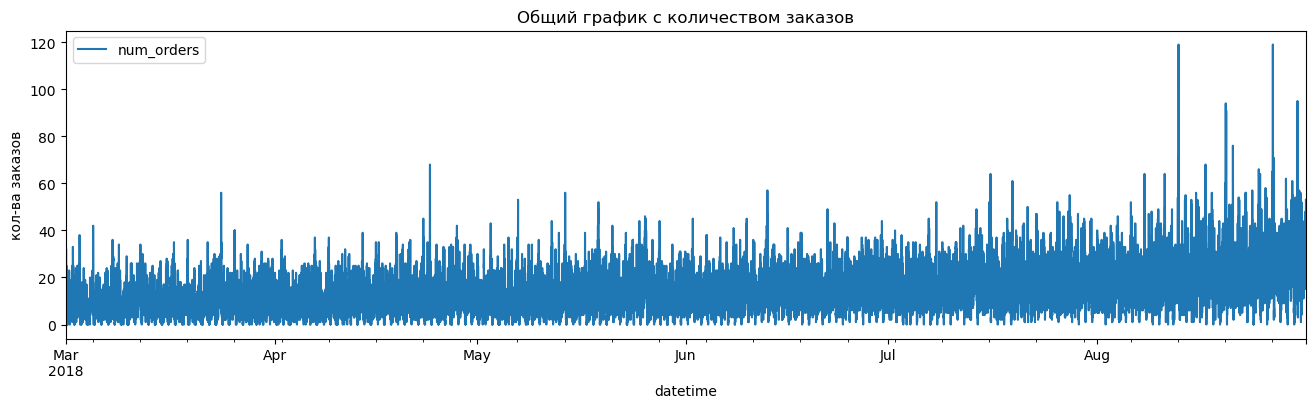

In [9]:
plt.figure(figsize=(16, 4))
plt.title('Общий график с количеством заказов')
plt.ylabel('кол-ва заказов')
plt.xlabel('время')
df.plot(ax=plt.gca())
plt.show()

### Промежуточный Вывод

Мы обрабатывали данные о заказах такси, которые простираются с марта по август 2018 года. Важным шагом было преобразование типа данных для столбца "Datetime" из объектного в формат datetime64, а также установление этого столбца в качестве индекса таблицы. После этого мы произвели проверку данных на наличие пропусков и убедились, что временной индекс является монотонным, что подтверждает правильное упорядочивание данных по времени. Эти предварительные шаги помогут нам далее проводить более точный и надежный анализ временных рядов заказов такси.

## Анализ

In [10]:
#ресемплирование по одному часу.
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


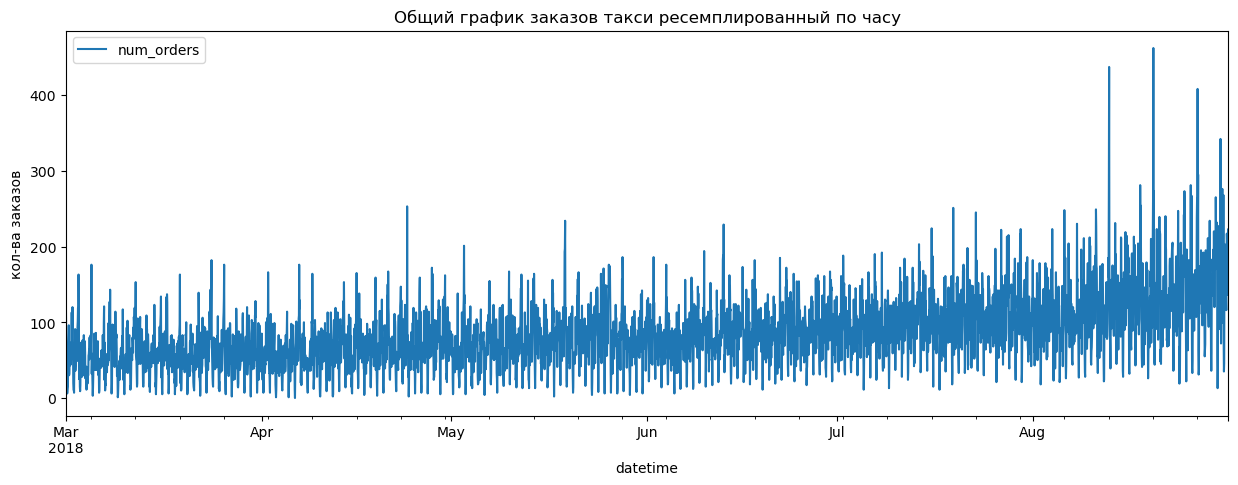

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Общий график заказов такси ресемплированный по часу')
plt.ylabel('кол-ва заказов')
plt.xlabel('время')
df.plot(ax=plt.gca())
plt.show()

Вычислим скользящее среднее взяв данные за 24 часа.

In [12]:
df['rolling_mean'] = df.shift().rolling(24).mean()
df

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,164.875000
2018-08-31 20:00:00,154,167.541667
2018-08-31 21:00:00,159,168.041667


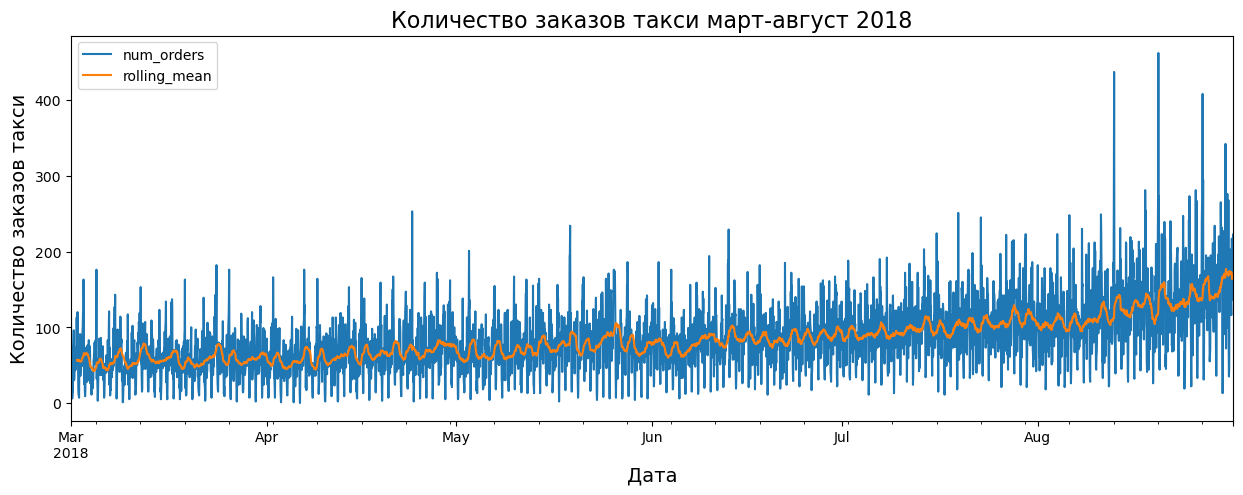

In [13]:
# построим график временного рядя
df.plot(figsize=(15,5))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Количество заказов такси март-август 2018', fontsize=16)
plt.legend()
plt.show()

как видим можно заметить восходящий тренд. Далее разделим его на тренды и сезонные явления

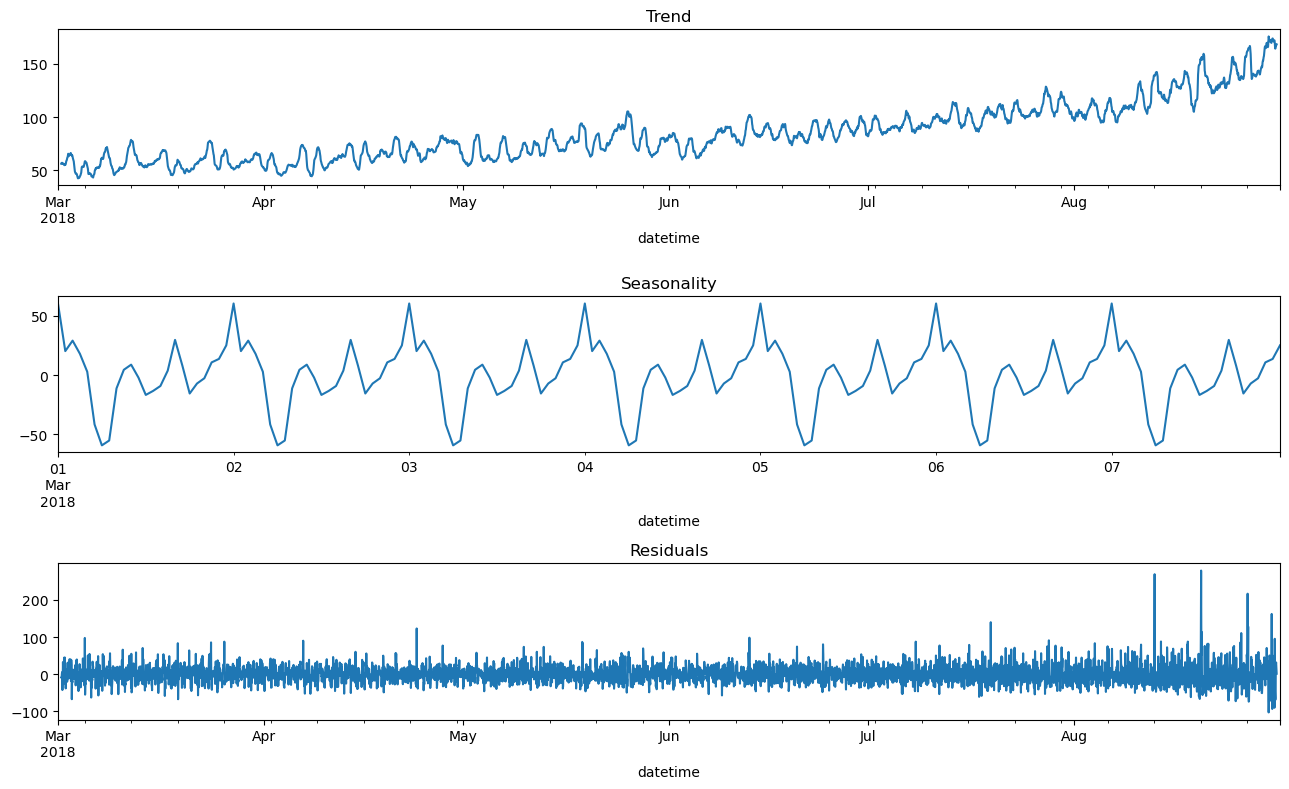

In [14]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.loc['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как видим на графике тренда постипенное увиличение, своего пика достигает в летние месяцы в августе.

In [15]:
#ресемплирование по неделе.
df_d = df.resample('D').sum()
df_d

,num_orders,rolling_mean
datetime,,
2018-03-01,1364,0.000000
2018-03-02,1506,1367.041667
2018-03-03,1290,1514.041667
2018-03-04,1141,1092.208333
2018-03-05,1259,1311.125000
...,...,...
2018-08-27,3936,3782.666667
2018-08-28,3357,3410.666667
2018-08-29,3762,3474.416667


In [16]:
df_d['weekday'] = df_d.index.weekday
mean_orders_by_weekday = df_d.groupby('weekday')['num_orders'].mean()
mean_orders_by_weekday

weekday
0    2165.923077
1    1848.269231
2    2010.115385
3    2055.851852
4    2187.370370
5    2012.346154
6    1895.807692
Name: num_orders, dtype: float64

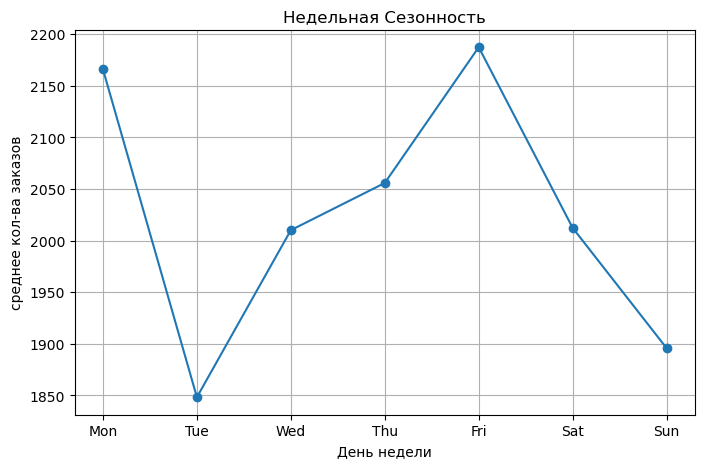

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(mean_orders_by_weekday.index, mean_orders_by_weekday.values, marker='o')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('День недели')
plt.ylabel('среднее кол-ва заказов')
plt.title('Недельная Сезонность')
plt.grid(True)
plt.show()

In [20]:
df = df.drop('rolling_mean', axis=1)

In [21]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [22]:
df.columns

Index(['num_orders'], dtype='object')

## Обучение

In [23]:
RANDOM_STATE = 12345

In [24]:
# Функция для дополнительных признаков для лучшего обучения моделей
def make_features(data, max_lag, rolling_mean_size):
    
    # добавим календарные признаки
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek.astype('category')
        
    # добавим сдвиги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['lag_week'] = data['num_orders'].shift(24 * 7)
        
    # добавим скользящее среднее
    data['rolling_mean_{}'.format(rolling_mean_size)] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    


In [25]:
make_features(df, 24, 24)
df.dropna(inplace=True)

In [26]:
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_week,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,8,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,124.0,60.041667
2018-03-08 01:00:00,78,8,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,85.0,61.833333
2018-03-08 02:00:00,65,8,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,71.0,60.041667
2018-03-08 03:00:00,68,8,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,66.0,61.750000
2018-03-08 04:00:00,60,8,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,43.0,61.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,113.0,164.875000
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,179.0,167.541667
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,166.0,168.041667


разделим на принак на целевой признак, и на обучающий и тестовые выборки

In [27]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

features, features_test, target,target_test= train_test_split(features, target, shuffle=False, test_size=0.1)

In [28]:
features.index[-1]

Timestamp('2018-08-14 06:00:00', freq='H')

In [29]:
target_test.index[0]

Timestamp('2018-08-14 07:00:00', freq='H')

In [30]:
print(f'Доля тренировочных признаков: {features.shape[0]/df.shape[0]:.2f}')
print(f'Доля тренировочных целей: {target.shape[0]/df.shape[0]:.2f}')
print(f'Доля тестовых признаков: {features_test.shape[0]/df.shape[0]:.2f}')
print(f'Доля тестовых целей: {target_test.shape[0]/df.shape[0]:.2f}')

Доля тренировочных признаков: 0.90
Доля тренировочных целей: 0.90
Доля тестовых признаков: 0.10
Доля тестовых целей: 0.10


### Константая модель

сначала найдлем резульаты для модели Дамми

In [31]:
# создадим модель
constant_model = DummyRegressor()

# обучим модеь
constant_model.fit(features, target)

# делаем прогноз
pred_previous = target_test.shift()
pred_previous.iloc[0] = target.iloc[-1]
predictions_constant = pred_previous

#смотрим метрику на тестовом
rmse_constant = mean_squared_error(target_test, predictions_constant, squared=False)
rmse_constant

58.819724582830204

### LinearRegression

In [32]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include=['category', 'object'])
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

In [33]:
#создадим пайплайн
pipe_lr = make_pipeline(
    linear_transformer,
    LinearRegression(
        n_jobs=-1
    )
)

In [34]:
tscv = TimeSeriesSplit(n_splits=3, gap=(24 * 7))

param_grid = {
    
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

In [36]:
%time gs_lr.fit(features, target)
None

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 172 ms
Wall time: 3.62 s


In [37]:
best_model_lr = gs_lr.best_estimator_
best_rmse_lr = -gs_lr.best_score_

# выводим лучшую модель и ее показатель 
print("Best Model:")
print(best_model_lr)
print("\nBest RMSE:")
print(best_rmse_lr)

Best Model:
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(dtype='uint8',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DFE1164350>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DFE112F210>)])),
                ('linearregression', LinearRegression(n_jobs=-1))])

Best RMSE:
23.66474587154317


### RandomForestRegressor

In [38]:
#создадим трансформер
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['object', 'category'])
    ),
    remainder='passthrough'
)

#Создадим pipeline
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestRegressor(
        oob_score=True,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
)

#сетку параметров и создадим estimator
param_grid = {
    'randomforestregressor__max_depth':np.arange(5, 16, 5)
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

In [39]:
#обучим модель
%time 
gs_rf.fit(features, target)
None

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [40]:
# лучшая модель и гиперпараметры
best_model_rf = gs_rf.best_estimator_
best_params_rf = gs_rf.best_params_
best_rmse_rf = -gs_rf.best_score_  

# выводим резлуьтаты
print("Best Model:", best_model_rf)
print("Best Parameters:", best_params_rf)
print("Best RMSE:", best_rmse_rf)

Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype='int16',
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DFE1118C50>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=15, n_jobs=-1, oob_score=True,
                                       random_state=12345))])
Best Parameters: {'randomforestregressor__max_depth': 15}
Best RMSE: 24.517083564106628


### LightGBM

In [41]:
#Создадим pipeline
pipe_gbm = make_pipeline(
    ensemble_transformer,
    lgb.LGBMRegressor(
        metric='rmse',
        n_jobs=-1,
        verbosity=-1,
        random_state=RANDOM_STATE
    )
)

#Зададим сетку параметров 
param_grid = {
    'lgbmregressor__max_depth':[-1, 10, 20],
    'lgbmregressor__num_leaves':[10, 31],
    'lgbmregressor__learning_rate':[.1, .5]
}
              
gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

In [42]:
#обучим модель
%time 
gs_gbm.fit(features, target)
None

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [43]:
# лучшая модель и гиперпараметры
best_model_gbm = gs_gbm.best_estimator_
best_params_gbm = gs_gbm.best_params_
best_rmse_gbm = -gs_gbm.best_score_  

# выводим резлуьтаты
print("Best Model:", best_model_gbm)
print("Best Parameters:", best_params_gbm)
print("Best RMSE:", best_rmse_gbm)

Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype='int16',
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DFE0AE6150>)])),
                ('lgbmregressor',
                 LGBMRegressor(metric='rmse', n_jobs=-1, num_leaves=10,
                               random_state=12345, verbosity=-1))])
Best Parameters: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': -1, 'lgbmregressor__num_leaves': 10}
Best RMSE: 24.36641982475744


### DecisionTree регрессия

In [44]:
# Создаем трансформер
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['object', 'category'])
    ),
    remainder='passthrough'
)

# Создаем пайплайн
pipe_dt = make_pipeline(
    ensemble_transformer,
    DecisionTreeRegressor(random_state=RANDOM_STATE)
)

# Задаем сетку гиперпараметров
param_grid = {
    'decisiontreeregressor__max_depth': [None, 5, 10, 15],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 5]
}

# Создаем объект GridSearchCV для поиска лучших гиперпараметров

gs_dt = GridSearchCV(
    pipe_dt,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

# Обучаем модель и ищем лучшие гиперпараметры
%time gs_dt.fit(features, target)

# Получаем лучшую модель и её RMSE
best_model_dt = gs_dt.best_estimator_
best_rmse_dt = -gs_dt.best_score_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
CPU times: total: 656 ms
Wall time: 978 ms


In [45]:
# лучшая модель и гиперпараметры
best_model_dt = gs_dt.best_estimator_
best_params_dt = gs_dt.best_params_
best_rmse_dt = -gs_dt.best_score_  

# выводим резлуьтаты
print("Best Model:", best_model_dt)
print("Best Parameters:", best_params_gbm)
print("Best RMSE:", best_rmse_dt)

Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype='int16',
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DFE0AD6150>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       random_state=12345))])
Best Parameters: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': -1, 'lgbmregressor__num_leaves': 10}
Best RMSE: 27.672515764324334


In [46]:
model_results = {
    'Model': ['LGBMRegressor', 'RandomForestRegressor', 'LinearRegression', 'DummyRegressor', 'DecisionTreeRegressor'],
    'RMSE': [best_rmse_gbm, best_rmse_rf, best_rmse_lr, rmse_constant, best_rmse_dt]
}

# Преобразование словаря в DataFrame

results_df= pd.DataFrame(model_results)
results_df.sort_values(by='RMSE')

,Model,RMSE
2,LinearRegression,23.664746
0,LGBMRegressor,24.366420
1,RandomForestRegressor,24.517084
4,DecisionTreeRegressor,27.672516
3,DummyRegressor,58.819725


как видим все наши модели пока что ниже 48(кроме Дамми) и лучше константной модели, лучшая на данный момент Линейнай регрессия

## Тестирование

Выберем для оценки на тесте модель LinearRegression.

In [47]:
# протестрируем на тестовом датасете
predictions_test_lr = best_model_lr.predict(features_test)


rmse_test_lr = mean_squared_error(target_test, predictions_test_lr, squared=False)
rmse_test_lr

34.599234937856416

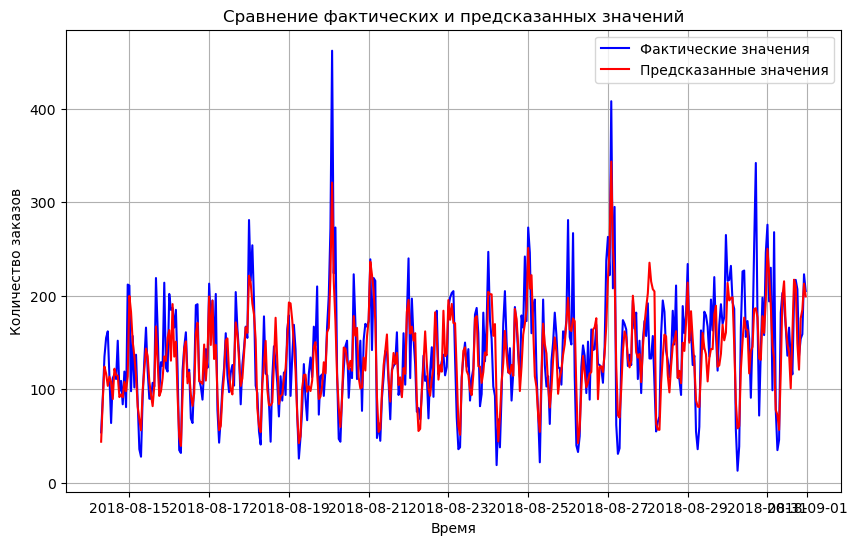

In [48]:
# Построение графика с фактическими значениями и предсказаниями
plt.figure(figsize=(10, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')
plt.plot(target_test.index, predictions_test_lr, label='Предсказанные значения', color='red')

plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

Выберем для оценки на тесте модель RandomForestRegressor.

In [51]:
predictions_test_rf = best_model_rf.predict(features_test)


rmse_test_rf = mean_squared_error(target_test, predictions_test_rf, squared=False)
rmse_test_rf

41.818090377984724

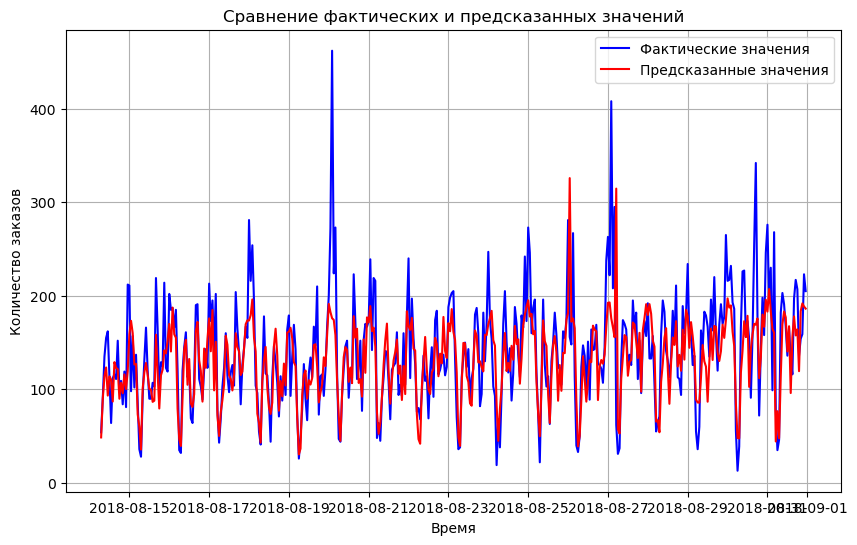

In [52]:
# Построение графика с фактическими значениями и предсказаниями
plt.figure(figsize=(10, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')
plt.plot(target_test.index, predictions_test_rf, label='Предсказанные значения', color='red')

plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

Выберем для оценки на тесте модель LightGBM.

In [53]:
predictions_test_gbm = best_model_gbm.predict(features_test)

rmse_test_gbm = mean_squared_error(target_test, predictions_test_gbm, squared=False)
rmse_test_gbm

38.76991865446708

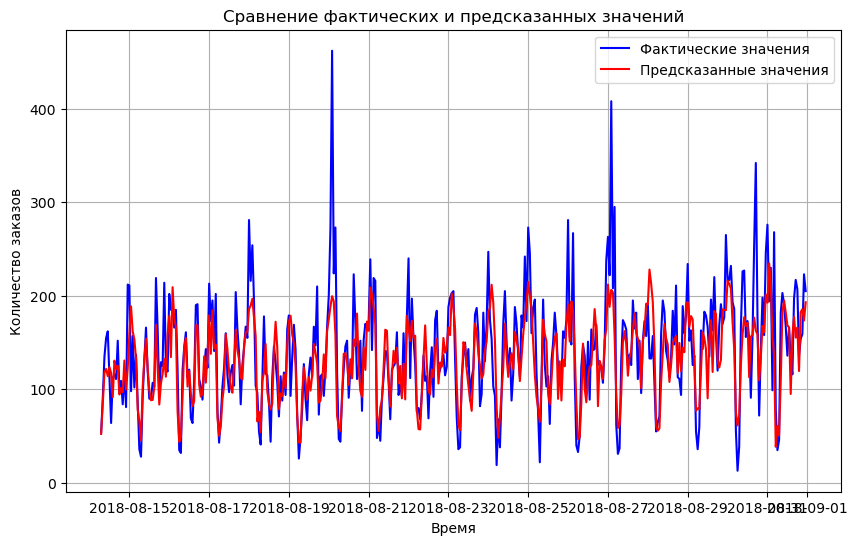

In [54]:
# Построение графика с фактическими значениями и предсказаниями
plt.figure(figsize=(10, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')
plt.plot(target_test.index, predictions_test_gbm, label='Предсказанные значения', color='red')

plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
predictions_test_dt = best_model_dt.predict(features_test)

rmse_test_dt = mean_squared_error(target_test, predictions_test_dt, squared=False)
rmse_test_dt

46.290200911608416

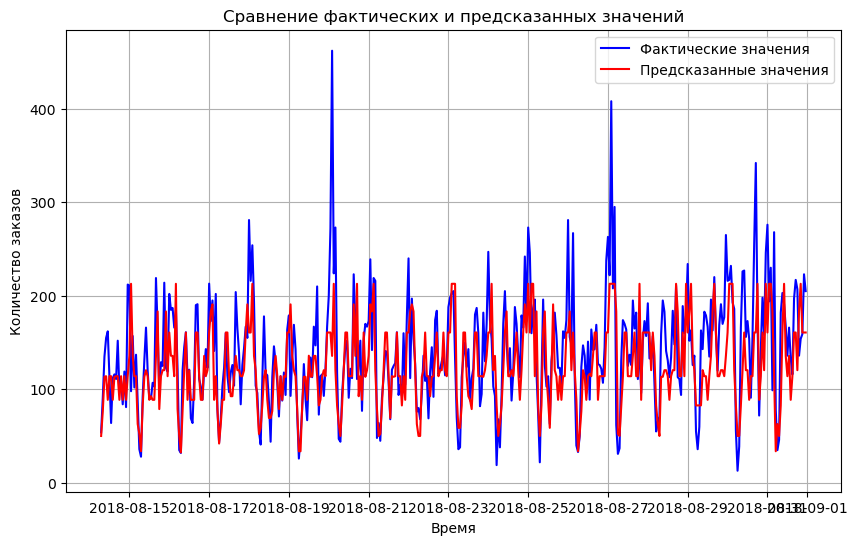

In [56]:
# Построение графика с фактическими значениями и предсказаниями
plt.figure(figsize=(10, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')
plt.plot(target_test.index, predictions_test_dt, label='Предсказанные значения', color='red')

plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
test_model_results = {
    'Model': ['LGBMRegressor', 'RandomForestRegressor', 'LinearRegression', 'DummyRegressor', 'DecisionTreeRegressor'],
    'RMSE': [rmse_test_gbm, rmse_test_rf, rmse_test_lr, rmse_constant, rmse_test_dt]
}

# Преобразование словаря в DataFrame

test_results_df= pd.DataFrame(test_model_results)
test_results_df.sort_values(by='RMSE')

,Model,RMSE
2,LinearRegression,34.599235
0,LGBMRegressor,38.769919
1,RandomForestRegressor,41.818090
4,DecisionTreeRegressor,46.290201
3,DummyRegressor,58.819725


## Общий вывод

В ходе анализа данных, я выполнил следующие шаги:

Провел предварительную обработку данных, включая сортировку по временному индексу, проверку на монотонность и рассемплирование ряда по часам. Также были выявлены тренды и сезонность в данных.

Обучил несколько моделей, включая линейную регрессию, дерево решений, случайный лес, CatBoostRegressor и LGBMRegressor. Также была оценена константная модель.

На основе обучающей выборки были найдены лучшие гиперпараметры для каждой модели с использованием метода кросс-валидации.

Проверил каждую модель с лучшими гиперпараметрами на тестовой выборке.

В результате, все модели показали хорошие результаты с метрикой RMSE не превышающей 48. Наилучшей моделью оказалась LinearRegression, результат RMSE 34 vs 58 у константной модели, что почти два раза больше. Таким образом, можно говорить что модель LinearRegression сильно опережает константую модель. Эту модель можно рекомендовать для использования в реальных условиях.

Таким образом, на основе проведенного анализа и сравнения моделей, мы определили оптимальную модель для прогнозирования и рекомендовали её для дальнейшего использования.